In [1]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn_pandas import DataFrameMapper
warnings.filterwarnings('ignore', category=DataConversionWarning)

def transform_date(df, field_name, drop=True):
    field = df[field_name]
    if not np.issubdtype(field, np.datetime64):
        df[field_name] = field = pd.to_datetime(field, infer_datetime_format=True)
    target_pre = re.sub('[Dd]ate$', '', field_name)
    for i in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[target_pre + i] = getattr(field.dt, i.lower())
    df[target_pre + 'Elapsed'] = field.astype(np.int64) // 10**9
    if drop:
        df.drop(field_name, axis=1, inplace=True)


def create_category_fields(df, is_train=True, train_df=None):  
    if is_train:
        for col_name, data in df.items():
            if is_string_dtype(data):
                df[col_name] = data.astype('category').cat.as_ordered()
    else:
        for col_name, data in df.items():
            if (col_name in train_df.columns) and (train_df[col_name].dtype.name == 'category'):
                df[col_name] = pd.Categorical(data, categories=train_df[col_name].cat.categories, ordered=True)



def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name + '_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique() > max_n_cat):
        df[name] = col.cat.codes + 1


def scale_vars(df, mapper):
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper


def preprocessing(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, mapper=None):

    if not skip_flds: 
        skip_flds = []
    df = df.copy()
    if preproc_fn: 
        preproc_fn(df)

    y = df[y_fld].values
    df.drop(skip_flds + [y_fld], axis=1, inplace=True)

    if na_dict is None: 
        na_dict = {}
    for n,c in df.items(): 
        na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: 
        mapper = scale_vars(df, mapper)
    for n,c in df.items(): 
        numericalize(df, c, n, max_n_cat)

    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]

    if do_scale: 
        res = res + [mapper]
    return res

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [2]:
import pandas as pd
import numpy as np
# from pandas.api.types import is_numeric_dtype, is_numeric_dtype


dep = 'SalePrice'
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')
keep_cols = list(np.load('tmp/keep_cols.npy'))

df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid


cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

for o in ['saleElapsed', 'saleDayofyear', 'saleDay', 'age', 'YearMade']: cat_flds.remove(o)
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]


for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds]
' '.join(cont_flds)

'YearMade saleElapsed SalesID MachineID saleDay saleDayofyear age'

In [3]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, nas, mapper = preprocessing(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))

In [4]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
from sklearn.metrics import r2_score

emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}

emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [5]:
from torch import nn
from torch.nn.init import kaiming_normal
import torch.nn.functional as F
import torch
from torch.optim import Adam, RMSprop
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pandas as pd

def split_by_idx(idxs, *a):
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]


def init_embeddings(x):
    x = x.weight.data
    value = 2 / (x.size(1) + 1)
    x.uniform_(-value, value)
    
class StructuredData(object):
    def __init__(self, df, y, cat_flds, cont_flds, val_index=None, batch_size=32, shuffle=False, num_workers=1):
        self.val_index = val_index
        if val_index:
            ((val_df, df), (y_val, y)) = split_by_idx(val_index, df, y)

        train_dataset = StructuredDataSet(df[cat_flds], df[cont_flds], y)
        
        if shuffle:
            train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        else:
            train_sampler = None
            
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=(train_sampler is None), 
                                       sampler=train_sampler, num_workers=num_workers)
        
        if val_index:
            validation_dataset = StructuredDataSet(val_df[cat_flds], val_df[cont_flds], y_val)
            self.validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, 
                                            num_workers=num_workers)
        else:
            self.validation_loader = None
            
    def get_data(self):  
        if self.val_index:
            return self.train_loader, self.validation_loader
        else:
            return self.train_loader  
    
class StructuredDataSet(Dataset):
    def __init__(self, cats, conts, y):
        self.cats = np.asarray(cats, dtype=np.int64)
        self.conts = np.asarray(conts, dtype=np.float32)
        self.N = len(y)
        y = np.zeros((n,1)) if y is None else y[:,None]
        self.y = np.asarray(y, dtype=np.float32)
            
    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    

     
class MultiInputNN(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, sizes, drops, y_range=None, use_bn=False, f=F.relu):
        super().__init__()
        # embedding layers
        self.embeddings = nn.ModuleList([nn.Embedding(insize, outsize) for insize, outsize in emb_szs])
        for layer in self.embeddings:
            init_embeddings(layer)
        self.num_categorical = sum([layer.embedding_dim for layer in self.embeddings])

        self.num_numerical = n_cont
        # linear layers
        sizes = [self.num_categorical + self.num_numerical] + sizes
        self.linear = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(size) for size in sizes[1:]])
        for layer in self.linear:
            kaiming_normal(layer.weight.data)
        # dropout layers
        
        self.emb_drop = nn.Dropout(emb_drop)
        self.drop_out = [nn.Dropout(drop) for drop in drops]
        # output layer
        self.output = nn.Linear(sizes[-1], 1)
        kaiming_normal(self.output.weight.data)
        self.f = f
        self.bn = nn.BatchNorm1d(self.num_numerical)
        self.use_bn = use_bn
        self.y_range = y_range

    def forward(self, x_cat, x_cont):
        if self.num_categorical > 0:
            X = [emb_layer(x_cat[:,i]) for i, emb_layer in enumerate(self.embeddings)]
            X = torch.cat(X, dim=1)
            X = self.emb_drop(X)
        if self.num_numerical > 0:
            X2 = self.bn(x_cont)
            X = torch.cat([X, X2], dim=1) if self.num_categorical != 0 else X2
        for linear, drop, norm in zip(self.linear, self.drop_out, self.bns):
            X = self.f(linear(X))
            if self.use_bn: 
                X = norm(X)
            X = drop(X)
        X = self.output(X)
        if self.y_range:
            X = F.sigmoid(X)
            X = X * (self.y_range[1] - self.y_range[0])
            X = X + self.y_range[0]
        return X
    
    
    def fit(self, train_loader, learning_rate=1e-3, batch_size=64, epochs=1, val_loader=None, metrics=None, save=False, save_path='tmp/checkpoint.pth.tar', 
                    pre_saved=False):

        loss = nn.MSELoss()
        optimizer = RMSprop(self.parameters(), lr=learning_rate)
        n_batches = int(train_loader.dataset.N / train_loader.batch_size)

        if pre_saved:
            checkpoint = torch.load(save_path)
            start_epoch = checkpoint['epoch']
            self.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('...restoring model...')
            
        begin = True
        for epoch_ in range(epochs):        
            if pre_saved:      
                if begin:
                    epoch = start_epoch
                    begin = False
            else:
                epoch = epoch_
            epoch += 1

            epoch_loss = 0.
            # train phase 
            self.train()
            for i, (batch_cat, batch_cont, batch_y) in enumerate(train_loader):
                optimizer.zero_grad()
                batch_cat, batch_cont, batch_y = Variable(batch_cat), Variable(batch_cont), Variable(batch_y)

                y_hat = self.forward(batch_cat, batch_cont)
                l = loss(y_hat, batch_y)
                epoch_loss += l.data[0]
                
                l.backward()
                optimizer.step()
                
                if i != 0 and i % 2000 == 0:
                    print('iteration: {} of n_batches: {}'.format(i, n_batches))
                    
            train_loss = epoch_loss / n_batches
            print_output = [epoch, train_loss]
            if val_loader:
                val_loss = self.validate(val_loader, loss, metrics)
                for i in val_loss: print_output.append(i)

            print(print_output)
        if save:
            state = {
            'epoch': epoch,
            'state_dict': self.state_dict(),
            'optimizer': optimizer.state_dict()}
            self.save_checkpoint(state, filename=save_path)

    def validate(self, val_loader, loss, metrics=None):
        self.eval()
        n_batches = int(val_loader.dataset.N / val_loader.batch_size)
        total_loss = 0.
        metric_scores = {}
        if metrics:
            for metric in metrics:
                metric_scores[str(metric)] = []
                
        for i, (batch_cat, batch_cont, batch_y) in enumerate(val_loader):
            batch_cat, batch_cont, batch_y = Variable(batch_cat), Variable(batch_cont), Variable(batch_y)
            y_hat = self.forward(batch_cat, batch_cont)
            l = loss(y_hat, batch_y)
            total_loss += l.data[0]
            
            if metrics:
                for metric in metrics:
                    metric_scores[str(metric)].append(metric(batch_y.data.numpy(), y_hat.data.numpy()))
        if metrics:
            final_metrics = []
            for metric in metrics:
                final_metrics.append(np.sum(metric_scores[str(metric)]) / n_batches)
            return total_loss / n_batches, final_metrics
        else:
            return total_loss / n_batches
        
        
    def save_checkpoint(self, state, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        
    def predict(self, df, cat_flds, cont_flds):
        print(self)
        self.eval()
        
        cats = np.asarray(df[cat_flds], dtype=np.int64)
        conts = np.asarray(df[cont_flds], dtype=np.float32)
        x_cat = Variable(torch.from_numpy(cats))
        x_cont = Variable(torch.from_numpy(conts))
        pred = self.forward(x_cat, x_cont)
        return pred.data.numpy().flatten()

    
# TODO
# - learning rate restarts
# change PATH for saved model? 

In [7]:
df_sample, y_sample, nas, mapper = preprocessing(df_raw[:10000], 'SalePrice', do_scale=True)

n_valid = 1000
n_trn = len(df_sample)-n_valid
val_idx = list(range(n_trn, len(df_sample)))

train_loader, val_loader = StructuredData(df_sample, y_sample, cat_flds, cont_flds, batch_size=64, val_index=val_idx).get_data()

In [8]:
y_range=(0,np.max(y)*1.2)
my_model = MultiInputNN(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05], use_bn=True, y_range=y_range)

In [9]:
my_model.fit(train_loader, epochs=2, save=True, val_loader=val_loader, metrics=[rmse, r2_score])

[1, 0.2800559032176222, 0.2120445171991984, [0.47285868326822916, 0.6394843271525947]]
[2, 0.13600565807095596, 0.1581528385480245, [0.40855414072672525, 0.7512905328215335]]


In [10]:
my_model.fit(train_loader, epochs=2, save=True, pre_saved=True)

...restoring model...
[3, 0.10581067510481391]
[4, 0.09245633615979126]


In [11]:
my_model.fit(train_loader, epochs=6, save=True, pre_saved=True, val_loader=val_loader, metrics=[rmse, r2_score])

...restoring model...
[5, 0.08438040920134102, 0.09725839048624038, [0.31948521931966145, 0.8743336750797489]]
[6, 0.07706897061850343, 0.09941337977846464, [0.32347993850708007, 0.8701445877842953]]
[7, 0.07329203292195285, 0.10904722313086192, [0.3393503189086914, 0.8500985956577293]]
[8, 0.06917939130216837, 0.10391043449441592, [0.33070348103841146, 0.860398260260472]]
[9, 0.06682882545781987, 0.09063390269875526, [0.30817171732584636, 0.8879943089702214]]
[10, 0.06284770334937743, 0.08417365128795305, [0.29730237325032555, 0.8997169686576142]]


In [31]:
preds = my_model.predict(df_sample, cat_flds, cont_flds)
# preds[:10]

In [27]:
rmse(y_sample, preds)

0.2226447360340913

In [10]:
import numpy as np
from bisect import bisect_right
from functools import partial
from torch.optim.optimizer import Optimizer

class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class CosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        self.optimizer = optimizer
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + np.cos(np.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]
    
    def _reset(self, epoch, T_max):
        """
        Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        return CosineAnnealingLR(self.optimizer, self.T_max, self.eta_min, last_epoch=epoch)

In [70]:
# HERE

from torch import nn
from torch.nn.init import kaiming_normal
import torch.nn.functional as F
import torch
from torch.optim import Adam, RMSprop
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from tqdm import tqdm_notebook, tnrange, tqdm

from torch.optim.optimizer import Optimizer


def split_by_idx(idxs, *a):
    mask = np.zeros(len(a[0]),dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask],o[~mask]) for o in a]


def init_embeddings(x):
    x = x.weight.data
    value = 2 / (x.size(1) + 1)
    x.uniform_(-value, value)
    

def SGD_Momentum(momentum):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)
    
class StructuredData(object):
    def __init__(self, df, y, cat_flds, cont_flds, val_index=None, batch_size=32, shuffle=False, num_workers=1):
        self.val_index = val_index
        if val_index:
            ((val_df, df), (y_val, y)) = split_by_idx(val_index, df, y)

        train_dataset = StructuredDataSet(df[cat_flds], df[cont_flds], y)
        
        if shuffle:
            train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        else:
            train_sampler = None
            
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=(train_sampler is None), 
                                       sampler=train_sampler, num_workers=num_workers)
        
        if val_index:
            validation_dataset = StructuredDataSet(val_df[cat_flds], val_df[cont_flds], y_val)
            self.validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, 
                                            num_workers=num_workers)
        else:
            self.validation_loader = None
            
    def get_data(self):  
        if self.val_index:
            return self.train_loader, self.validation_loader
        else:
            return self.train_loader  
    
class StructuredDataSet(Dataset):
    def __init__(self, cats, conts, y):
        self.cats = np.asarray(cats, dtype=np.int64)
        self.conts = np.asarray(conts, dtype=np.float32)
        self.N = len(y)
        y = np.zeros((n,1)) if y is None else y[:,None]
        self.y = np.asarray(y, dtype=np.float32)
            
    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    

     
class MultiInputNN(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, sizes, drops, y_range=None, use_bn=False, f=F.relu):
        super().__init__()
        # embedding layers
        self.embeddings = nn.ModuleList([nn.Embedding(insize, outsize) for insize, outsize in emb_szs])
        for layer in self.embeddings:
            init_embeddings(layer)
        self.num_categorical = sum([layer.embedding_dim for layer in self.embeddings])
        self.num_numerical = n_cont
        # linear layers
        sizes = [self.num_categorical + self.num_numerical] + sizes
        self.linear = nn.ModuleList([nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(size) for size in sizes[1:]])
        for layer in self.linear:
            kaiming_normal(layer.weight.data)
        # dropout layers 
        self.emb_drop = nn.Dropout(emb_drop)
        self.drop_out = [nn.Dropout(drop) for drop in drops]
        # output layer
        self.output = nn.Linear(sizes[-1], 1)
        kaiming_normal(self.output.weight.data)
        self.f = f
        self.bn = nn.BatchNorm1d(self.num_numerical)
        self.use_bn = use_bn
        self.y_range = y_range

    def forward(self, x_cat, x_cont):
        if self.num_categorical > 0:
            X = [emb_layer(x_cat[:,i]) for i, emb_layer in enumerate(self.embeddings)]
            X = torch.cat(X, dim=1)
            X = self.emb_drop(X)
        if self.num_numerical > 0:
            X2 = self.bn(x_cont)
            X = torch.cat([X, X2], dim=1) if self.num_categorical != 0 else X2
        for linear, drop, norm in zip(self.linear, self.drop_out, self.bns):
            X = self.f(linear(X))
            if self.use_bn: 
                X = norm(X)
            X = drop(X)
        X = self.output(X)
        if self.y_range:
            X = F.sigmoid(X)
            X = X * (self.y_range[1] - self.y_range[0])
            X = X + self.y_range[0]
        return X
    

def fit(model, train_loader, loss, opt_fn=None, learning_rate=1e-3, batch_size=64, epochs=1, cycle_len=1, val_loader=None, metrics=None, 
                save=False, save_path='tmp/checkpoint.pth.tar', pre_saved=False, print_period=1000):
        
    if opt_fn:
        optimizer = opt_fn(model.parameters(), lr=learning_rate)
    else:  
        optimizer = RMSprop(model.parameters(), lr=learning_rate)
    # for stepper 
    n_batches = int(len(train_loader.dataset) // train_loader.batch_size)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_batches*cycle_len)
    global all_lr
    all_lr = []
    
    best_val_loss = np.inf
    
    if pre_saved:
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('...restoring model...')
    begin = True
    
    for epoch_ in tnrange(1, epochs+1, desc='Epoch'):
        
        if pre_saved:      
            if begin:
                epoch = start_epoch
                begin = False
        else:
            epoch = epoch_
        
        # training
        train_loss = train(model, train_loader, optimizer, scheduler, loss, print_period)
        
        print_output = [epoch, train_loss]
        
        # validation
        if val_loader:
            val_loss = validate(model, val_loader, optimizer, loss, metrics)
            if val_loss[0] < best_val_loss:
                best_val_loss = val_loss[0]
                
                # save model     
                if save:
                    if save_path:
                        ensure_dir(save_path)
                        state = {
                            'epoch': epoch,
                            'state_dict': model.state_dict(),
                            'best_val_loss': best_val_loss,
                            'optimizer': optimizer.state_dict()
                        }
                        save_checkpoint(state, save_path=save_path)
                        
            for i in val_loss: print_output.append(i)

        # epoch, train loss, val loss, metrics (optional)
        print(print_output)

        # reset scheduler
        if epoch_ % cycle_len == 0:
            scheduler = scheduler._reset(epoch, T_max=n_batches*cycle_len)
        
        epoch += 1
    
def train(model, train_loader, optimizer, scheduler, loss, print_period=1000):

    epoch_loss = 0.
    n_batches = int(train_loader.dataset.N / train_loader.batch_size)
    model.train()
    
    for i, (batch_cat, batch_cont, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        batch_cat, batch_cont, batch_y = Variable(batch_cat), Variable(batch_cont), Variable(batch_y)

        y_hat = model.forward(batch_cat, batch_cont)
        l = loss(y_hat, batch_y)
        epoch_loss += l.data[0]

        l.backward()
        optimizer.step()
        # scheduler
        scheduler.step()
        all_lr.append(scheduler.get_lr())

        if i != 0 and i % print_period == 0:
            statement = '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(i, n_batches, i / n_batches)
#             print('iteration: {} of n_batches: {}'.format(i, n_batches))
            sys.stdout.write('\r' + statement)
            sys.stdout.flush()
            

    train_loss = epoch_loss / n_batches
    return train_loss

def validate(model, val_loader, optimizer, loss, metrics=None):
    model.eval()
    n_batches = int(val_loader.dataset.N / val_loader.batch_size)
    total_loss = 0.
    metric_scores = {}
    if metrics:
        for metric in metrics:
            metric_scores[str(metric)] = []

    for i, (batch_cat, batch_cont, batch_y) in enumerate(val_loader):
        batch_cat, batch_cont, batch_y = Variable(batch_cat), Variable(batch_cont), Variable(batch_y)
        y_hat = model.forward(batch_cat, batch_cont)
        l = loss(y_hat, batch_y)
        total_loss += l.data[0]

        if metrics:
            for metric in metrics:
                metric_scores[str(metric)].append(metric(batch_y.data.numpy(), y_hat.data.numpy()))
    if metrics:
        final_metrics = []
        for metric in metrics:
            final_metrics.append(np.sum(metric_scores[str(metric)]) / n_batches)
        return total_loss / n_batches, final_metrics
    else:
        return total_loss / n_batches


def save_checkpoint(state, save_path='tmp/checkpoint.pth.tar'):
    torch.save(state, save_path)

def predict(model, df, cat_flds, cont_flds):
    model.eval()

    cats = np.asarray(df[cat_flds], dtype=np.int64)
    conts = np.asarray(df[cont_flds], dtype=np.float32)
    x_cat = Variable(torch.from_numpy(cats))
    x_cont = Variable(torch.from_numpy(conts))
    pred = model.forward(x_cat, x_cont)
    return pred.data.numpy().flatten()

def load_model(model, save_path='tmp/checkpoint.pth.tar'):
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def save_model(model, save_path='tmp/checkpoint.pth.tar'):
    model.save_state_dict(save_path)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [71]:
df_sample, y_sample, nas, mapper = preprocessing(df_raw[:10000], 'SalePrice', do_scale=True)

n_valid = 1000
n_trn = len(df_sample)-n_valid
val_idx = list(range(n_trn, len(df_sample)))

train_loader, val_loader = StructuredData(df_sample, y_sample, cat_flds, cont_flds, batch_size=64, val_index=val_idx).get_data()

In [72]:
y_range=(0,np.max(y)*1.2)
model = MultiInputNN(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05], use_bn=True, y_range=y_range)

In [73]:
fit(model, train_loader, loss=nn.MSELoss(), epochs=3, save=True, val_loader=val_loader, 
                                                    metrics=[rmse, r2_score], cycle_len=2)

A Jupyter Widget

[1, 1.639220580458641, 0.5799732963244121, [0.7782540003458659, -0.09781987565455008]]
[2, 0.39279980223093713, 0.40360497136910756, [0.6502052307128906, 0.26504784751982624]]
[3, 0.34502676384789605, 0.2712958832581838, [0.5327951113382975, 0.524008665094589]]



In [62]:
fit(model, train_loader, loss=nn.MSELoss(), epochs=3, save=True, pre_saved=True, val_loader=val_loader, metrics=[rmse, r2_score], cycle_len=1)

...restoring model...


A Jupyter Widget

[3, 0.21934471300670078, '*', 0.21485466063022612, [0.47674404780069984, 0.6358352228969051]]
[4, 0.18640141364719187, '*', 0.1857215995589892, [0.44271872838338217, 0.6980171309709788]]
[5, 0.1532136854316507, '*', 0.1452785814801852, [0.39229167302449547, 0.7745209904333218]]



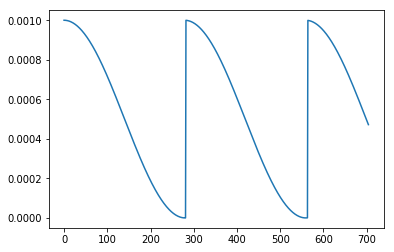

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(all_lr)

In [96]:


 ### in your training loop ####


# # learning rate schduler -------
# lr = LR.get_rate(i)
# if lr<0 : break
# adjust_learning_rate(optimizer, lr)
# rate = get_learning_rate(optimizer)[0]  # read lr for debugging
# print(i, rate)
        

## simple stepping rates
class StepLR():
    def __init__(self, pairs):
        super(StepLR, self).__init__()

        N=len(pairs)
        rates=[]
        steps=[]
        for n in range(N):
            s, r = pairs[n]
            if r <0: s= s+1
            steps.append(s)
            rates.append(r)

        self.rates = rates
        self.steps = steps

    def get_rate(self, epoch=None):

        N = len(self.steps)
        lr = -1
        for n in range(N):
            if epoch >= self.steps[n]:
                lr = self.rates[n]
        return lr

    def __str__(self):
        string = 'Step Learning Rates\n' \
                + 'rates=' + str(['%7.4f' % i for i in self.rates]) + '\n' \
                + 'steps=' + str(['%7.0f' % i for i in self.steps]) + ''
        return string


# ## https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
class DecayLR():
    def __init__(self, base_lr, decay, step):
        super(DecayLR, self).__init__()
        self.step  = step
        self.decay = decay
        self.base_lr = base_lr

    def get_rate(self, epoch=None, num_epoches=None):
        lr = self.base_lr * (self.decay**(epoch // self.step))
        return lr



    def __str__(self):
        string = '(Exp) Decay Learning Rates\n' \
                + 'base_lr=%0.3f, decay=%0.3f, step=%0.3f'%(self.base_lr, self.decay, self.step)
        return string


In [156]:
cycle_len = 2
epoch_ = 2

for epoch_ in range(5):
    epoch_ 
    print(epoch_ % cycle_len)

1
2
3
4
5


In [77]:
import math
from bisect import bisect_right
from functools import partial
from torch.optim.optimizer import Optimizer

class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class CosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2

                for base_lr in self.base_lrs]
    
    def _reset(self):
        
        return self.base_lrs
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
#         if new_base_lr != None:
#             self.base_lr = new_base_lr
#         if new_max_lr != None:
#             self.max_lr = new_max_lr
#         if new_step != None:
#             self.step = new_step
#         self.clr_iterations = 0.
    
    
# Training settings
batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [79]:
# 'Cyclical Learning Rates for Training Neural Networks'- Leslie N. Smith, arxiv 2017
#       https://arxiv.org/abs/1506.01186
#       https://github.com/bckenstler/CLR

class CosAnneal(LR_Updater):
    def __init__(self, nb, on_cycle_end=None, cycle_mult=1):
        self.nb, self.on_cycle_end, self.cycle_mult = nb, on_cycle_end, cycle_mult

    def on_train_begin(self):
        self.cycle_iter,self.cycle_count=0,0
        super().on_train_begin()

    def calc_lr(self, init_lrs):
        if self.iteration<self.nb/20:
            self.cycle_iter += 1
            return init_lrs/100.

        cos_out = np.cos(np.pi*(self.cycle_iter)/self.nb) + 1
        self.cycle_iter += 1
        if self.cycle_iter == self.nb:
            self.cycle_iter = 0
            self.nb *= self.cycle_mult
            if self.on_cycle_end: 
                self.on_cycle_end(self, self.cycle_count)
            self.cycle_count += 1
        return init_lrs / 2 * cos_out
    
#     def reset(self, init_lrs):
#         self.on_train_begin()
       
# cycle_len (int):  number of cycles before lr is reset to the initial value.
                #E.g if cycle_len = 3, then the lr is varied between a maximum
                #and minimum value over 3 epochs.

    


class CyclicLR():

    def __init__(self, base_lr=0.001, max_lr=0.006, step=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step = step
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: (0.5)**(x-1)
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step != None:
            self.step = new_step
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step))
        x = np.abs(self.clr_iterations/self.step - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def get_rate(self, epoch=None, num_epoches=None):

        self.trn_iterations += 1
        self.clr_iterations += 1
        lr = self.clr()

        return lr

    def __str__(self):
        string = 'Cyclical Learning Rates\n' \
                + 'base_lr=%0.3f, max_lr=%0.3f'%(self.base_lr, self.max_lr)
        return string
    

NameError: name 'LR_Updater' is not defined

In [105]:
import math
from bisect import bisect_right
from functools import partial
from torch.optim.optimizer import Optimizer

class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch + 1)
        self.last_epoch = last_epoch

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class CosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(CosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2

                for base_lr in self.base_lrs]
    
    def _reset(self, optimizer):
        
        CosineAnnealingLR()
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
    
## rates  ------------------------------
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
        lr += [param_group['lr']]
    return lr


def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [134]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np



class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x)


model = Net()
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer_ft = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5)
n_batches = len(train_loader.dataset) // train_loader.batch_size
scheduler = CosineAnnealingLR(optimizer, T_max=n_batches)


# LR = StepLR([ (0, 0.001),  (12800,0.0001),  (32000,0.00001),  (61000,-1)])
# optimizer = optim.RMSprop(model.parameters(), lr=0.1, momentum=0.9)
# # LR = CyclicLR()
# time = 0
# n_batches = len(train_loader.dataset) // train_loader.batch_size
# # cos_out = np.cos(np.pi*(time)/n_batches) + 1
# clr_fn = lambda x: np.cos(np.pi*(x)/n_batches) + 1
# clr = CyclicLR(base_lr=learning_rate, max_lr=0.5, scale_fn=clr_fn, step=len(train_loader.dataset.train_labels))

# # learning rate schduler -------
# lr = LR.get_rate(i)
# if lr<0 : break
# adjust_learning_rate(optimizer, lr)
# rate = get_learning_rate(optimizer)[0]  # read lr for debugging
# print(i, rate)
all_lr = []
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        all_lr.append(scheduler.get_lr())
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
#     exp_lr_scheduler._reset(optimizer_ft)
#     new_rate = get_learning_rate(optimizer)[0]  
#     print(new_rate)
    
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10):
    train(epoch)
    test()

#     scheduler._reset(optimizer)
#     print(scheduler.get_lr())
    scheduler = CosineAnnealingLR(optimizer, T_max=n_batches)
#     rate = get_learning_rate(optimizer_ft)[0]
#     print(rate)

/Users/mattevanoff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293382
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.595026
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.405382
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.469636
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.272411
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.247376
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.147518
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.206779
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.199622
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.282829
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.307455
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.318879
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.131003
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.209618
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.199217
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.149596
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.237026
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.098327
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.274271
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.163927
Train Epoch:

KeyboardInterrupt: 

937

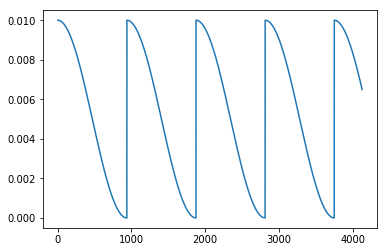

In [135]:
plt.plot(all_lr)

In [59]:
def fun(x, init_lrs):
    cos_out = np.cos(np.pi*(x)/n_batches) + 1
    return init_lrs / 2 * cos_out

def fun2(base_lr, T_max, eta_min, last_epoch):
    return eta_min + (base_lr - eta_min) * (1 + np.cos(math.pi * last_epoch / T_max)) / 2

In [60]:
x = np.arange(0, n_batches)

In [69]:
y = fun(1, init_lrs=0.01)
y_2 = fun2(0.01, n_batches, 0, 1)

In [70]:
print(y_2)
print(y)

0.009999971896515835
0.009999971896515835


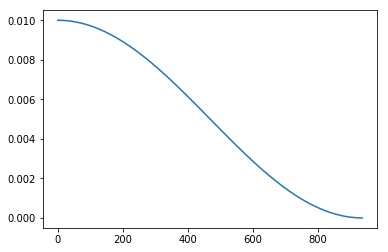

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y)

In [50]:
x2 = np.arange(n_batches, n_batches*2)

In [51]:
y2 = fun(x2, init_lrs=0.01)

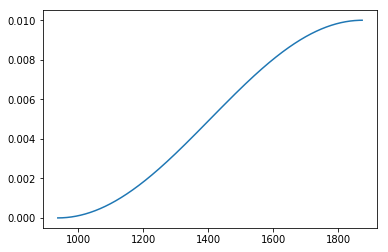

In [52]:
plt.plot(x2, y2)

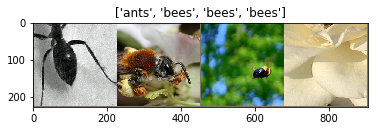

In [113]:

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
# The problem we're going to solve today is to train a model to classify
# **ants** and **bees**. We have about 120 training images each for ants and bees.
# There are 75 validation images for each class. Usually, this is a very
# small dataset to generalize upon, if trained from scratch. Since we
# are using transfer learning, we should be able to generalize reasonably
# well.
#
# This dataset is a very small subset of imagenet.
#
# .. Note ::
#    Download the data from
#    `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
#    and extract it to the current directory.

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [123]:

######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.

all_lr = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                all_lr.append(scheduler.get_lr())
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

num_epochs=25

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=dataset_sizes['train'] // num_epochs)

######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/24
----------
train Loss: 0.6952 Acc: 0.6516
val Loss: 0.2108 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4658 Acc: 0.8443
val Loss: 0.1516 Acc: 0.9673

Epoch 2/24
----------
train Loss: 0.4492 Acc: 0.8156
val Loss: 0.2316 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4106 Acc: 0.8279
val Loss: 0.1794 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4851 Acc: 0.7828
val Loss: 0.1576 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4563 Acc: 0.8033
val Loss: 0.2209 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.2799 Acc: 0.9057
val Loss: 0.1506 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2537 Acc: 0.8893
val Loss: 0.1428 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2733 Acc: 0.8934
val Loss: 0.1499 Acc: 0.9477

Epoch 9/24
----------


Process Process-94:
Process Process-96:
Process Process-93:
Process Process-95:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/mattevanoff/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/matte

KeyboardInterrupt: 

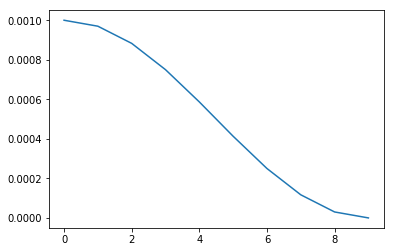

In [124]:
plt.plot(all_lr)

In [ ]:
######################################################################
#

######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)


visualize_model(model_ft)


######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()

In [1]:
import sys
 
sys.stdout.write("This")
sys.stdout.write("Is")
sys.stdout.write("Single")
sys.stdout.write("Line")

ThisIsSingleLine

In [5]:
import sys

for x in range(10):
    sys.stdout.write('\r'+str(x))
    sys.stdout.flush()

9